In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [10]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("Built with CUDA:", tf.test.is_built_with_cuda())
# print("GPU available:", tf.config.list_physical_devices('GPU'))


In [11]:
# 1. Load and preprocess dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')

In [12]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [13]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [14]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [15]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [17]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 1 CNN: Acc=0.6283, Prec=0.6235, Rec=0.6283, F1=0.6252, MCC=0.3793, MSE=0.5543, RMSE=0.7445, R2=-0.1891


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Fold 1 RNN: Acc=0.5891, Prec=0.5856, Rec=0.5891, F1=0.5870, MCC=0.3200, MSE=0.6343, RMSE=0.7965, R2=-0.3608


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Fold 1 LSTM: Acc=0.6317, Prec=0.6312, Rec=0.6317, F1=0.6304, MCC=0.3940, MSE=0.5637, RMSE=0.7508, R2=-0.2092


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 2 CNN: Acc=0.6145, Prec=0.6302, Rec=0.6145, F1=0.6198, MCC=0.3793, MSE=0.6196, RMSE=0.7872, R2=-0.3539


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 2 RNN: Acc=0.5958, Prec=0.5875, Rec=0.5958, F1=0.5903, MCC=0.3136, MSE=0.6016, RMSE=0.7756, R2=-0.3145


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
Fold 2 LSTM: Acc=0.6227, Prec=0.6184, Rec=0.6227, F1=0.6196, MCC=0.3627, MSE=0.5418, RMSE=0.7361, R2=-0.1839


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Fold 3 CNN: Acc=0.6198, Prec=0.6185, Rec=0.6198, F1=0.6172, MCC=0.3654, MSE=0.5810, RMSE=0.7622, R2=-0.2834


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Fold 3 RNN: Acc=0.6088, Prec=0.5992, Rec=0.6088, F1=0.6017, MCC=0.3296, MSE=0.5611, RMSE=0.7491, R2=-0.2395


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Fold 3 LSTM: Acc=0.6276, Prec=0.6183, Rec=0.6276, F1=0.6204, MCC=0.3622, MSE=0.5497, RMSE=0.7414, R2=-0.2144


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4 CNN: Acc=0.6256, Prec=0.6174, Rec=0.6256, F1=0.6191, MCC=0.3632, MSE=0.5364, RMSE=0.7324, R2=-0.1652


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 4 RNN: Acc=0.5979, Prec=0.5965, Rec=0.5979, F1=0.5938, MCC=0.3318, MSE=0.6115, RMSE=0.7820, R2=-0.3285


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Fold 4 LSTM: Acc=0.6298, Prec=0.6233, Rec=0.6298, F1=0.6242, MCC=0.3756, MSE=0.5348, RMSE=0.7313, R2=-0.1618


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 5 CNN: Acc=0.6238, Prec=0.6218, Rec=0.6238, F1=0.6211, MCC=0.3700, MSE=0.5522, RMSE=0.7431, R2=-0.2168


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Fold 5 RNN: Acc=0.5983, Prec=0.5909, Rec=0.5983, F1=0.5935, MCC=0.3181, MSE=0.6044, RMSE=0.7774, R2=-0.3317


c:\Users\Joshua Ean\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Fold 5 LSTM: Acc=0.6325, Prec=0.6257, Rec=0.6325, F1=0.6258, MCC=0.3729, MSE=0.5207, RMSE=0.7216, R2=-0.1475


In [18]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.6224
precision: 0.6223
recall: 0.6224
f1: 0.6205
mcc: 0.3715
mse: 0.5687
rmse: 0.7539
r2: -0.2417

RNN Average Metrics:
accuracy: 0.5980
precision: 0.5920
recall: 0.5980
f1: 0.5933
mcc: 0.3226
mse: 0.6026
rmse: 0.7761
r2: -0.3150

LSTM Average Metrics:
accuracy: 0.6288
precision: 0.6234
recall: 0.6288
f1: 0.6241
mcc: 0.3735
mse: 0.5421
rmse: 0.7362
r2: -0.1834


In [33]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [40]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print("\nOverall Best Model: LSTM")
print("This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to CNN and RNN, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is LSTM (score: 0.6288)
For precision, the winner is LSTM (score: 0.6234)
For recall, the winner is LSTM (score: 0.6288)
For f1, the winner is LSTM (score: 0.6241)
For mcc, the winner is LSTM (score: 0.3735)
For mse, the winner is LSTM (score: 0.5421)
For rmse, the winner is LSTM (score: 0.7362)
For r2, the winner is LSTM (score: -0.1834)

Overall Best Model: LSTM
This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to CNN and RNN, indicating it generalizes better on this sentiment classification task.


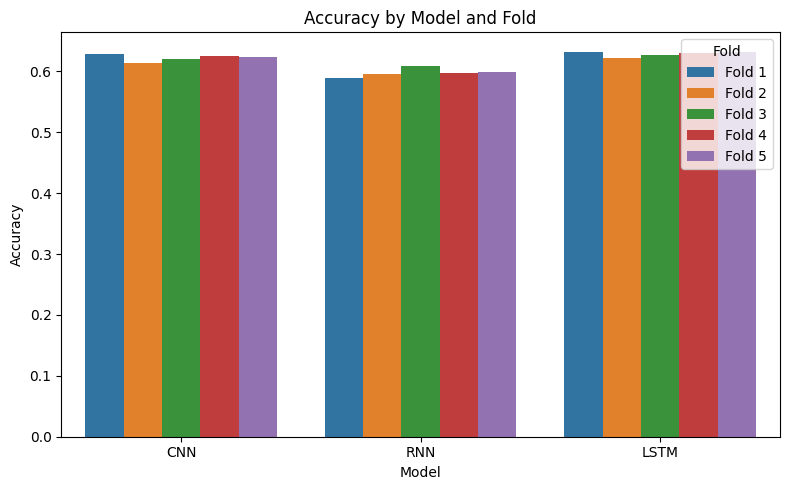

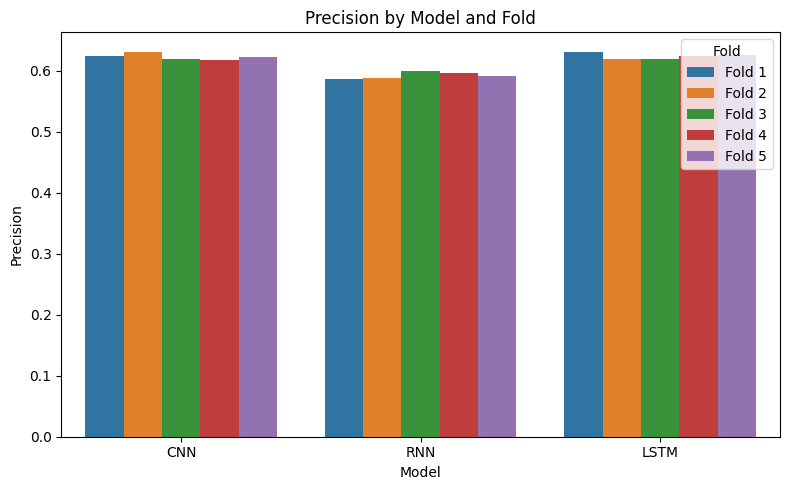

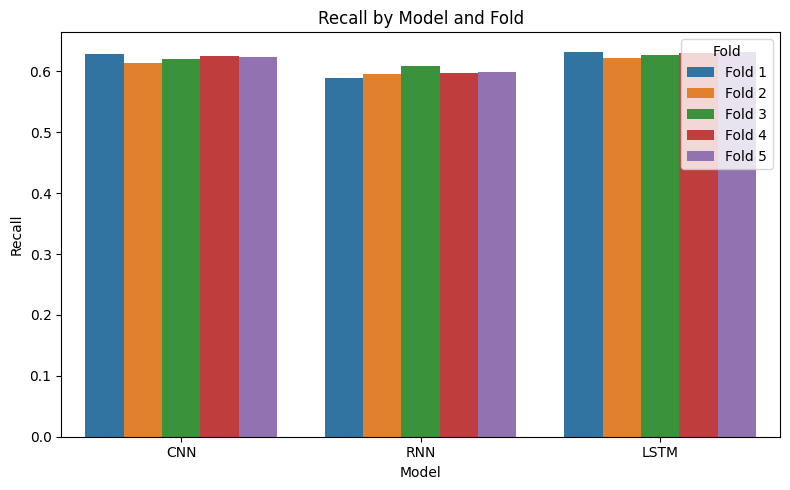

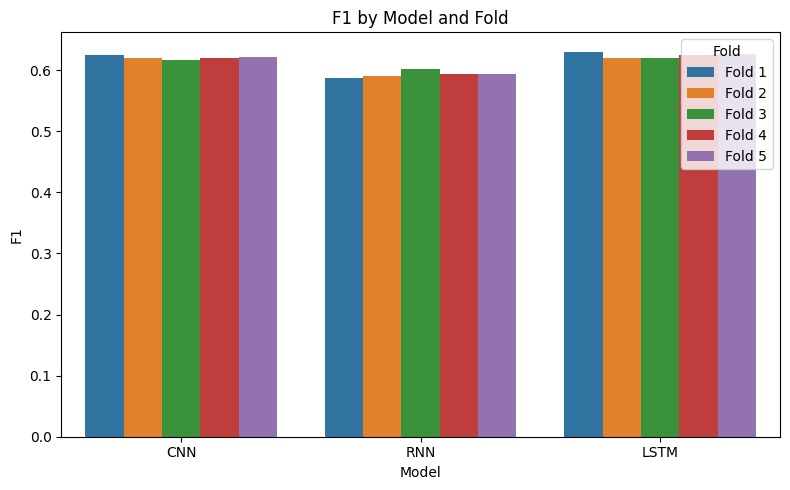

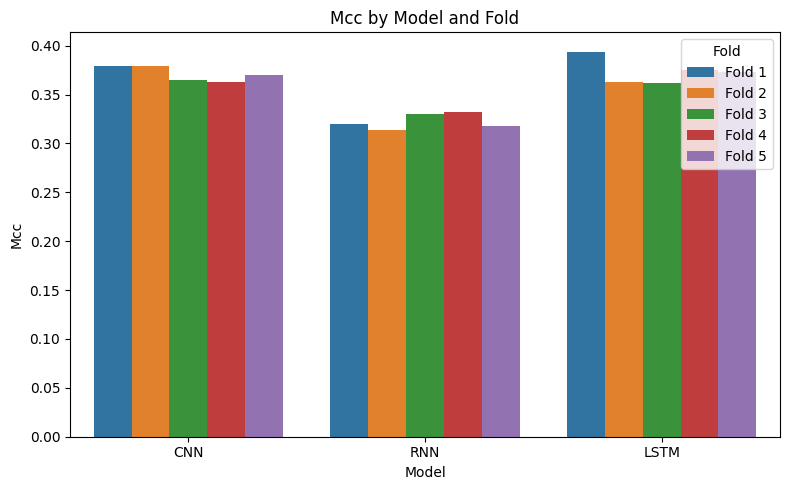

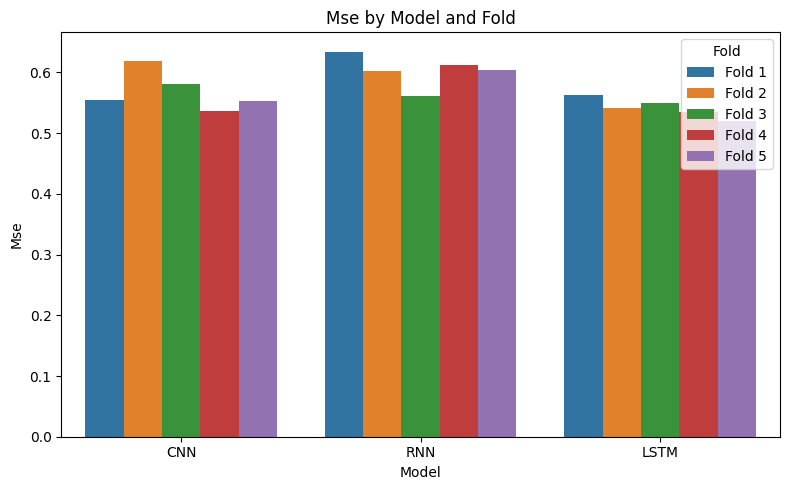

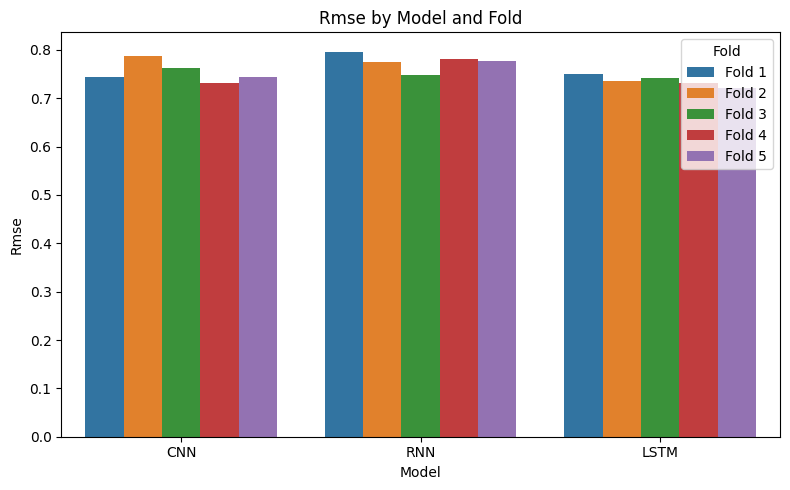

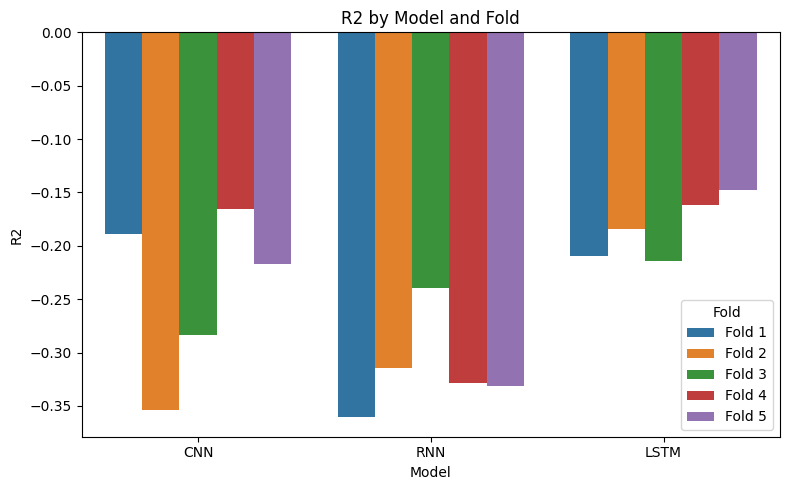

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()